# AfriSenti - Multilingual Sentiment Analysis

Sentiment Analysis (Multilingual Tweets)

**Authors:** Ainedembe Denis, Musinguzi Benson  
**Lecturer:** Dr. Sitenda Harriet

This notebook implements a comprehensive analysis of the AfriSenti dataset, the largest sentiment analysis dataset for under-represented African languages, covering 110,000+ annotated tweets in 14 African languages.

[## 1. Imports & Installs

In [1]:
# Import necessary libraries for sentiment analysis assignment

%pip install -q "datasets<4.0.0" pandas numpy

# Check Python version environment
import sys
python_version = sys.version_info
print(f"Using Python ({python_version})")

# Data loading and manipulation
from datasets import load_dataset, get_dataset_config_names
import pandas as pd
import numpy as np

# Visualization (for data exploration, confusion matrix, attention visualization)
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation metrics (F1-score, accuracy, ROC-AUC, confusion matrix)
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split

# Deep Learning - PyTorch (for fine-tuning XLM-RoBERTa/AfriBERTa and LSTM)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_

import time

# Import scheduler
try:
    from transformers import get_linear_schedule_with_warmup
except ImportError:
    from transformers.optimization import get_linear_schedule_with_warmup


# Transformers (for mBERT, XLM-RoBERTa tokenizers and models)
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification
)

import re

# Progress bars
from tqdm import tqdm
print("All packages imported successfully")


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Using Python (sys.version_info(major=3, minor=11, micro=9, releaselevel='final', serial=0))


c:\Users\Ainedembe-Denis\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All packages imported successfully


In [ ]:
# Download NLTK data (run once)
try:
    import nltk
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
    print("NLTK data downloaded")
except:
    print("NLTK data download skipped (may already be installed)")

NLTK data downloaded


## 2. Loading the Dataset

2.1.1 Loading the Dataset and Listing some available language configurations

In [2]:
# Load Dataset from Datasets library

print("LISTING AVAILABLE LANGUAGE CONFIGURATIONS FOR AfriSenti-Twitter DATASET")
print("__" * 65)

configs = get_dataset_config_names("HausaNLP/AfriSenti-Twitter", trust_remote_code=True)
print("Available language configs:", configs)

# Example: load Amharic (amh) with all splits (train/validation/test)
print("\nLoading Amharic (amh) with all splits")
print("-" * 40)
amh_ds = load_dataset("HausaNLP/AfriSenti-Twitter", "amh", trust_remote_code=True)
print(amh_ds)

# Example: load a single split (train) only
print("\nLoading a single split /train only for Amharic (amh):")
print("-" * 90)
amh_train = load_dataset("HausaNLP/AfriSenti-Twitter", "amh", split="train", trust_remote_code=True)
print(amh_train[0])


LISTING AVAILABLE LANGUAGE CONFIGURATIONS FOR AfriSenti-Twitter DATASET
__________________________________________________________________________________________________________________________________
Available language configs: ['amh', 'hau', 'ibo', 'arq', 'ary', 'yor', 'por', 'twi', 'tso', 'tir', 'orm', 'pcm', 'kin', 'swa']

Loading Amharic (amh) with all splits
----------------------------------------
DatasetDict({
    train: Dataset({
        features: ['tweet', 'label'],
        num_rows: 5984
    })
    validation: Dataset({
        features: ['tweet', 'label'],
        num_rows: 1497
    })
    test: Dataset({
        features: ['tweet', 'label'],
        num_rows: 1999
    })
})

Loading a single split /train only for Amharic (amh):
------------------------------------------------------------------------------------------
{'tweet': 'Tesfaye ለካስ ጭብል ለብሰሽ የፕሮፌሰርን ፎቶ ለጥፈክ እልም ያልክ ባዳ ነክ እፈር ትንሽ', 'label': 2}


2.1.2. Dataset Sample: Displaying one sample tweet from each of the 14 languages, showing the dataset structure and multilingual nature.


In [3]:
# Display one example tweet from each language

print("DATASET SAMPLE: One Example from Each Language")
print("_" * 75)

# Label mapping: 0=negative, 1=neutral, 2=positive
label_to_sentiment = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Collect one example from each language
sample_data = []

# Get all available language configurations
configs = get_dataset_config_names("HausaNLP/AfriSenti-Twitter", trust_remote_code=True)

print(f"\nLoading one sample from each of {len(configs)} languages...\n")

for lang in sorted(configs):
    try:
        # Try to load train split first, then validation, then test
        sample = None
        for split in ['train', 'validation', 'test']:
            try:
                ds = load_dataset("HausaNLP/AfriSenti-Twitter", lang, split=split, trust_remote_code=True)
                if len(ds) > 0:
                    sample = ds[0]
                    break
            except ValueError:
                continue

        if sample is not None:
            # Truncate tweet to 50 characters for display
            tweet_text = sample['tweet'][:50] + '...' if len(sample['tweet']) > 50 else sample['tweet']
            sample_data.append({
                'Lang.': lang,
                'Tweet': tweet_text,
                'Sentiment': label_to_sentiment.get(sample['label'], 'Unknown')
            })
    except Exception as e:
        print(f"Warning: Could not load sample for {lang}: {e}")
        continue

# Create DataFrame and display in table format
if sample_data:
    sample_df = pd.DataFrame(sample_data)

    # Configure pandas display options for better table formatting
    pd.set_option('display.max_colwidth', 50)  # Tweet text truncated to 50 chars + '...'
    pd.set_option('display.width', 100)
    pd.set_option('display.max_rows', None)  # Show all rows

    # Display the table
    print("\n" + "-" * 75)
    print(sample_df.to_string(index=False))
    print("-" * 75)
    print(f"\nTotal languages shown: {len(sample_df)}/{len(configs)}")
    print("_" * 75)
else:
    print("No samples could be loaded.")


DATASET SAMPLE: One Example from Each Language
___________________________________________________________________________

Loading one sample from each of 14 languages...


---------------------------------------------------------------------------
Lang.                                                 Tweet Sentiment
  amh Tesfaye ለካስ ጭብል ለብሰሽ የፕሮፌሰርን ፎቶ ለጥፈክ እልም ያልክ ባዳ ነክ...  Positive
  arq @user على حسب موقعك يبدو أنك صاحب نظرة ثاقبة .يخي ...  Positive
  ary hhhhhhhhhhhhhhhhhhhhhh ana ga3ma sma3tt ach kant k...   Neutral
  hau @user Da kudin da Arewa babu wani abin azo agani d...  Positive
  ibo          Nna Ike Gwuru ooo. 😂 https://t.co/NDS7juFBGd  Positive
  kin @user @user @user @user @user @user @user Hhhhhh n...  Positive
  orm @user Waa’ee mana waaqeffanaa ilaalcha keessa galc...   Neutral
  pcm yeah ‍️the guy wants to trend dat was why e join n...  Positive
  por Pedi uma resposta a Deus, ele deu me. Estou muito ...  Positive
  swa Kwani tanesco wanakataga umeme makusudinadha

2.2. Map language codes to full language names



In [4]:
# Language code to name mapping
language_names = {
    'amh': 'Amharic',
    'hau': 'Hausa',
    'ibo': 'Igbo',
    'arq': 'Algerian Arabic',
    'ary': 'Moroccan Arabic',
    'yor': 'Yoruba',
    'por': 'Portuguese',
    'twi': 'Twi',
    'tso': 'Tsonga',
    'tir': 'Tigrinya',
    'orm': 'Oromo',
    'pcm': 'Nigerian Pidgin',
    'kin': 'Kinyarwanda',
    'swa': 'Swahili'
}

print("Language Code & Language Name Mapping:")
print("_" * 50)
for code, name in sorted(language_names.items()):
    print(f"  {code:4s} - {name}")


Language Code & Language Name Mapping:
__________________________________________________
  amh  - Amharic
  arq  - Algerian Arabic
  ary  - Moroccan Arabic
  hau  - Hausa
  ibo  - Igbo
  kin  - Kinyarwanda
  orm  - Oromo
  pcm  - Nigerian Pidgin
  por  - Portuguese
  swa  - Swahili
  tir  - Tigrinya
  tso  - Tsonga
  twi  - Twi
  yor  - Yoruba


2.3. Tweets summary across all 14 languages.

In [5]:
# Total tweets across all languages
# Dataset Summary (size, languages, total tweets)

print("Language configs:", configs)

summary_rows = []
for cfg in configs:
    # Load each split individually to handle cases where some splits don't exist
    n_train = 0
    n_val = 0
    n_test = 0

    try:
        train_ds = load_dataset("HausaNLP/AfriSenti-Twitter", cfg, split="train", trust_remote_code=True)
        n_train = len(train_ds)
    except ValueError:
        n_train = 0

    try:
        val_ds = load_dataset("HausaNLP/AfriSenti-Twitter", cfg, split="validation", trust_remote_code=True)
        n_val = len(val_ds)
    except ValueError:
        n_val = 0

    try:
        test_ds = load_dataset("HausaNLP/AfriSenti-Twitter", cfg, split="test", trust_remote_code=True)
        n_test = len(test_ds)
    except ValueError:
        n_test = 0

    total = n_train + n_val + n_test
    summary_rows.append({
        "lang": cfg,
        "train": n_train,
        "validation": n_val,
        "test": n_test,
        "total": total
    })

summary_df = pd.DataFrame(summary_rows).set_index("lang")
print(summary_df)
print("\nTotal tweets across all languages:", summary_df["total"].sum())


Language configs: ['amh', 'hau', 'ibo', 'arq', 'ary', 'yor', 'por', 'twi', 'tso', 'tir', 'orm', 'pcm', 'kin', 'swa']
      train  validation  test  total
lang                                
amh    5984        1497  1999   9480
hau   14172        2677  5303  22152
ibo   10192        1841  3682  15715
arq    1651         414   958   3023
ary    5583         494  2961   9038
yor    8522        2090  4515  15127
por    3063         767  3662   7492
twi    3481         388   949   4818
tso     804         203   254   1261
tir       0         398  2000   2398
orm       0         396  2096   2492
pcm    5121        1281  4154  10556
kin    3302         827  1026   5155
swa    1810         453   748   3011

Total tweets across all languages: 111718


## 3. Initial Data Exploration: Analyzing language distribution, text length, and label imbalance.

3.1. Load train data from all languages


In [43]:
# Load train data from all languages.

configs = get_dataset_config_names("HausaNLP/AfriSenti-Twitter", trust_remote_code=True)
train_dataframes = []

# Track loading statistics
loading_stats = []

for lang in configs:
    try:
        train_ds = load_dataset("HausaNLP/AfriSenti-Twitter", lang, split="train", trust_remote_code=True)
        df = train_ds.to_pandas()
        df['lang'] = lang  # Add language column
        train_dataframes.append(df)
        loading_stats.append({
            'Language Code': lang,
            'Language Name': language_names.get(lang, 'Unknown'),
            'Train Samples': len(df),
            'Status': 'Loaded'
        })
    except ValueError:
        loading_stats.append({
            'Language Code': lang,
            'Language Name': language_names.get(lang, 'Unknown'),
            'Train Samples': 0,
            'Status': 'No train split'
        })
        continue

# Display loading statistics in a table
loading_df = pd.DataFrame(loading_stats)

print("Dataset Loading Summary")
print("-" * 70)
print(loading_df.to_string(index=False))
print("-" * 70)

# Combine all languages into one dataframe
train_df = pd.concat(train_dataframes, ignore_index=True)
print(f"\nTotal train samples loaded: {len(train_df):,}")

# Map label numbers to text (0=negative, 1=neutral, 2=positive)
label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
train_df['label_text'] = train_df['label'].map(label_map)

# Add language name column
train_df['lang_name'] = train_df['lang'].map(language_names)

print("\nFirst few rows:")
print(train_df[['lang', 'lang_name', 'tweet', 'label', 'label_text']].head())


Dataset Loading Summary
----------------------------------------------------------------------
Language Code   Language Name  Train Samples         Status
          amh         Amharic           5984         Loaded
          hau           Hausa          14172         Loaded
          ibo            Igbo          10192         Loaded
          arq Algerian Arabic           1651         Loaded
          ary Moroccan Arabic           5583         Loaded
          yor          Yoruba           8522         Loaded
          por      Portuguese           3063         Loaded
          twi             Twi           3481         Loaded
          tso          Tsonga            804         Loaded
          tir        Tigrinya              0 No train split
          orm           Oromo              0 No train split
          pcm Nigerian Pidgin           5121         Loaded
          kin     Kinyarwanda           3302         Loaded
          swa         Swahili           1810         Loaded
-----

3.2. Language Distribution on the Train Set

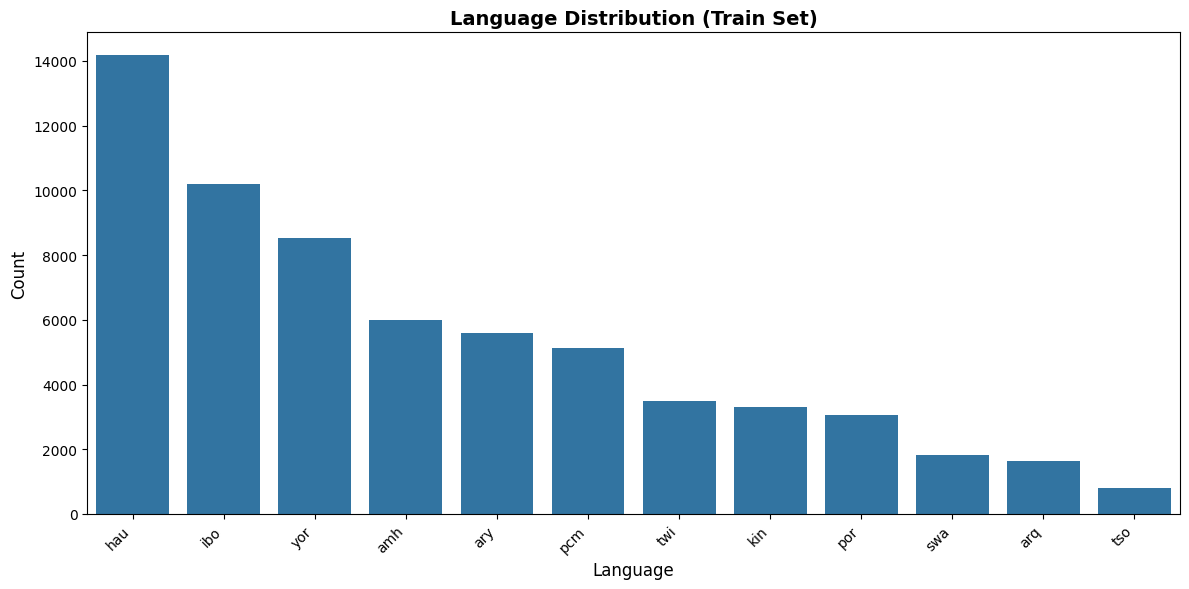

Language counts:
lang
amh     5984
arq     1651
ary     5583
hau    14172
ibo    10192
kin     3302
pcm     5121
por     3063
swa     1810
tso      804
twi     3481
yor     8522
Name: count, dtype: int64


In [44]:
# Language Distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='lang', order=train_df['lang'].value_counts().index)
plt.title("Language Distribution (Train Set)", fontsize=14, fontweight='bold')
plt.xlabel("Language", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Language counts:")
print(train_df['lang'].value_counts().sort_index())


3.3. Text Length Analysis on Train Set

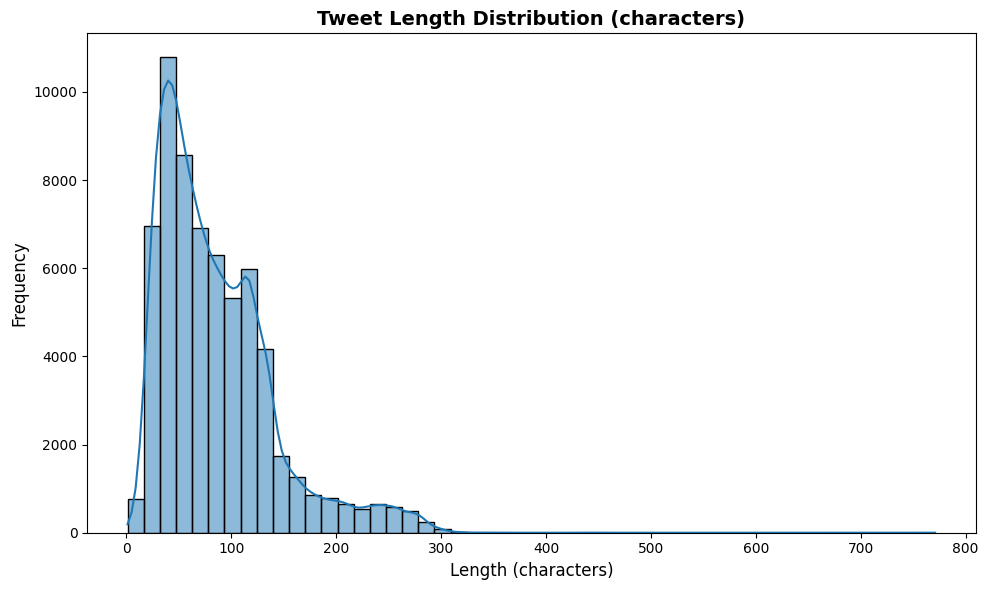

Text length statistics:
count    63685.000000
mean        85.523781
std         55.263220
min          1.000000
25%         44.000000
50%         73.000000
75%        115.000000
max        771.000000
Name: text_len, dtype: float64

Min length: 1
Max length: 771
Mean length: 85.52
Median length: 73.00


In [45]:
# Text length (in characters)

train_df['text_len'] = train_df['tweet'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_len'], bins=50, kde=True)
plt.title("Tweet Length Distribution (characters)", fontsize=14, fontweight='bold')
plt.xlabel("Length (characters)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

print(f"Text length statistics:")
print(train_df['text_len'].describe())
print(f"\nMin length: {train_df['text_len'].min()}")
print(f"Max length: {train_df['text_len'].max()}")
print(f"Mean length: {train_df['text_len'].mean():.2f}")
print(f"Median length: {train_df['text_len'].median():.2f}")


3.4. Label Distribution (Overall)

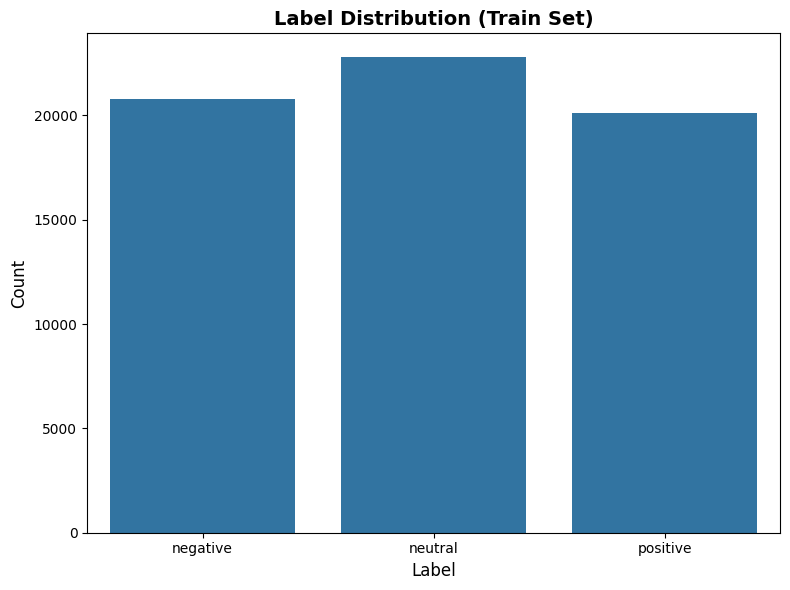

Label counts:
label_text
neutral     22794
negative    20783
positive    20108
Name: count, dtype: int64

Label percentages:
label_text
neutral     35.791788
negative    32.634058
positive    31.574154
Name: proportion, dtype: float64


In [46]:
# Label Distribution (Overall)

plt.figure(figsize=(8, 6))
sns.countplot(data=train_df, x='label_text', order=['negative', 'neutral', 'positive'])
plt.title("Label Distribution (Train Set)", fontsize=14, fontweight='bold')
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()

print("Label counts:")
print(train_df['label_text'].value_counts())
print("\nLabel percentages:")
print(train_df['label_text'].value_counts(normalize=True) * 100)


3.5. Label Distribution by Language

Label distribution by language:
label_text  negative  neutral  positive
lang                                   
amh             1332     3104      1548
arq              417      342       892
ary             1758     2161      1664
hau             4687     4912      4573
ibo             3084     4508      2600
kin              899     1257      1146
pcm             1808       72      3241
por              681     1600       782
swa              547     1072       191
tso              384      136       284
twi             1644      522      1315
yor             3542     3108      1872


<Figure size 1400x800 with 0 Axes>

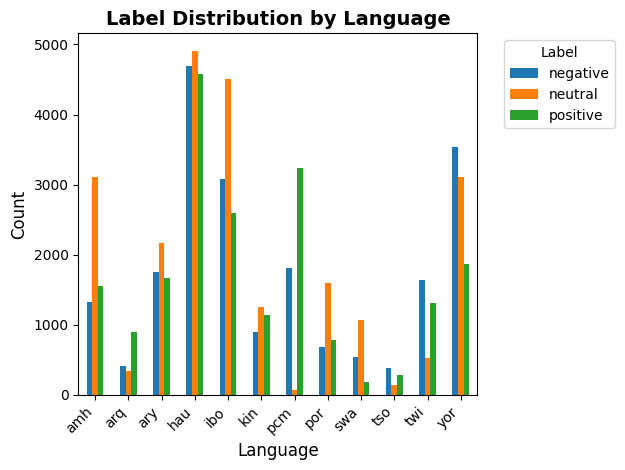

<Figure size 1400x800 with 0 Axes>

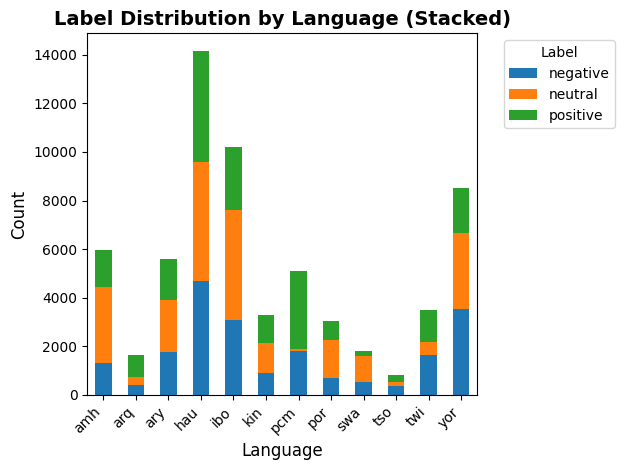

In [47]:
# Label Distribution by Language
label_by_lang = train_df.groupby(['lang', 'label_text']).size().unstack(fill_value=0)
print("Label distribution by language:")
print(label_by_lang)

# Visualize label distribution by language
plt.figure(figsize=(14, 8))
label_by_lang.plot(kind='bar', stacked=False)
plt.title("Label Distribution by Language", fontsize=14, fontweight='bold')
plt.xlabel("Language", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Stacked bar chart for better comparison
plt.figure(figsize=(14, 8))
label_by_lang.plot(kind='bar', stacked=True)
plt.title("Label Distribution by Language (Stacked)", fontsize=14, fontweight='bold')
plt.xlabel("Language", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 4. Preprocess text using multilingual tokenizers (mBERT, XLM-RoBERTa). Handle emojis, URLs, and slang normalization.
4.1. Load train, validation, and test datasets from all languages

In [6]:
# Load train, validation, and test datasets from all languages
configs = get_dataset_config_names("HausaNLP/AfriSenti-Twitter", trust_remote_code=True)

train_datasets = []
val_datasets = []
test_datasets = []

for lang in configs:
    try:
        train_ds = load_dataset("HausaNLP/AfriSenti-Twitter", lang, split="train", trust_remote_code=True)
        train_datasets.append(train_ds)
    except ValueError:
        pass

    try:
        val_ds = load_dataset("HausaNLP/AfriSenti-Twitter", lang, split="validation", trust_remote_code=True)
        val_datasets.append(val_ds)
    except ValueError:
        pass

    try:
        test_ds = load_dataset("HausaNLP/AfriSenti-Twitter", lang, split="test", trust_remote_code=True)
        test_datasets.append(test_ds)
    except ValueError:
        pass

# Concatenate all languages
from datasets import concatenate_datasets

train_ds = concatenate_datasets(train_datasets) if train_datasets else None
val_ds = concatenate_datasets(val_datasets) if val_datasets else None
test_ds = concatenate_datasets(test_datasets) if test_datasets else None

print(f"Train samples: {len(train_ds) if train_ds else 0}")
print(f"Validation samples: {len(val_ds) if val_ds else 0}")
print(f"Test samples: {len(test_ds) if test_ds else 0}")


Train samples: 63685
Validation samples: 13726
Test samples: 34307


4.2. Text preprocessing: handle URLs, mentions, hashtags, and normalize spacing

In [7]:
# Text preprocessing function
# AfriSenti already anonymised mentions and removed URLs, but we'll still have a simple cleaner

def clean_text(text: str) -> str:
    # Just in case there are extra URLs or weird spacing
    text = re.sub(r"http\S+|www\.\S+", " <URL> ", text)  # URLs
    text = re.sub(r"@\w+", " <USER> ", text)             # Mentions
    text = re.sub(r"#(\w+)", r"\1", text)                # Remove # but keep word
    text = re.sub(r"\s+", " ", text).strip()             # Normalize whitespace
    # Emojis are left as-is; XLM-R/mBERT will handle them.
    return text

def preprocess_batch(batch):
    """Apply text cleaning to a batch of examples."""
    batch["tweet"] = [clean_text(t) for t in batch["tweet"]]
    return batch

# Apply preprocessing
train_ds = train_ds.map(preprocess_batch, batched=True)
val_ds = val_ds.map(preprocess_batch, batched=True)
test_ds = test_ds.map(preprocess_batch, batched=True)

print("Text preprocessing completed")
print("\nSample preprocessed tweets:")
for i in range(3):
    print(f"  {i+1}. {train_ds[i]['tweet']}")


Text preprocessing completed

Sample preprocessed tweets:
  1. Tesfaye ለካስ ጭብል ለብሰሽ የፕሮፌሰርን ፎቶ ለጥፈክ እልም ያልክ ባዳ ነክ እፈር ትንሽ
  2. ይሄው ነው አይደል የእውቀትሽ ጥግ....በሰሚ ሰሚ ከምትናገሪ ለምን ታሪክ አታነቢም....ደሞ ራስሽን አታስገምቺ
  3. ዘገበ ይባላል? ሌላ የሚባል ነገር ካለ አንተዉ ንገረን!


4.3. Label mapping & encoding: from string to int (0=negative, 1=neutral, 2=positive)

In [8]:
# Label mapping: string -> int (0=negative, 1=neutral, 2=positive)
# But we create mappings for consistency

label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

print("Label mappings:")
print(f" - label2id: {label2id}")
print(f" - id2label: {id2label}\n")

# Ensure labels are integers
def encode_labels(batch):
    # Labels are already numeric, but ensure they're int type
    batch["label_id"] = [int(l) for l in batch["label"]]
    return batch

train_ds = train_ds.map(encode_labels, batched=True)
val_ds = val_ds.map(encode_labels, batched=True)
test_ds = test_ds.map(encode_labels, batched=True)

print("\nLabel encoding completed\n")


Label mappings:
 - label2id: {'negative': 0, 'neutral': 1, 'positive': 2}
 - id2label: {0: 'negative', 1: 'neutral', 2: 'positive'}


Label encoding completed



4.4. Tokenizing the tweets using mBERT / XLM-RoBERTa multilingual tokenizer.

In [9]:
# multilingual tokenizers XLM-RoBERTa or mBERT

# Option 1: XLM-RoBERTa tokenizer  (default)
transformer_name = "xlm-roberta-base"

# Option 2: mBERT tokenizer (uncomment to use instead)
# transformer_name = "bert-base-multilingual-cased"

print(f"Loading multilingual tokenizer: {transformer_name}")

tokenizer = AutoTokenizer.from_pretrained(transformer_name)
print(f"Tokenizer loaded successfully: {transformer_name}")
print(f"  Vocabulary size: {tokenizer.vocab_size:,}")

max_length = 128  # we can change this later in ablations
print(f"\nMax sequence length: {max_length}")

def tokenize_batch(batch):
    #Tokenize a batch of tweets using multilingual tokenizer.
    encoded = tokenizer(
        batch["tweet"],
        truncation=True,
        padding="max_length",
        max_length=max_length
    )
    encoded["labels"] = batch["label_id"]
    return encoded

# Tokenize datasets
print("\nTokenizing datasets with multilingual tokenizer\n")
train_tok = train_ds.map(tokenize_batch, batched=True)
val_tok = val_ds.map(tokenize_batch, batched=True)
test_tok = test_ds.map(tokenize_batch, batched=True)

print("\nTokenization completed using multilingual tokenizer")
print(f"Tokenizer used: {transformer_name}")

Loading multilingual tokenizer: xlm-roberta-base
Tokenizer loaded successfully: xlm-roberta-base
  Vocabulary size: 250,002

Max sequence length: 128

Tokenizing datasets with multilingual tokenizer



Map: 100%|██████████| 13726/13726 [00:01<00:00, 9167.35 examples/s]



Tokenization completed using multilingual tokenizer
Tokenizer used: xlm-roberta-base


4.5. Converting tokenized datasets to PyTorch format and creating DataLoaders for batch processing during model training.

In [52]:
# PyTorch Formatting: Convert datasets to PyTorch tensors

# Check if tokenized datasets exist, if not create them
if 'train_tok' not in globals() or 'val_tok' not in globals() or 'test_tok' not in globals():
    print("Tokenized datasets not found. Creating them now...")

    # Check if required variables exist
    if 'train_ds' not in globals() or 'val_ds' not in globals() or 'test_ds' not in globals():
        raise NameError("train_ds, val_ds, or test_ds not found. Please run the data loading and preprocessing cells first.")

    if 'tokenizer' not in globals():
        print("Tokenizer not found. Loading tokenizer...")
        if 'transformer_name' not in globals():
            transformer_name = "xlm-roberta-base"
        tokenizer = AutoTokenizer.from_pretrained(transformer_name)
        print(f"Tokenizer loaded: {transformer_name}")

    if 'max_length' not in globals():
        max_length = 128

    # Tokenization function
    def tokenize_batch(batch):
        """Tokenize a batch of tweets using multilingual tokenizer."""
        encoded = tokenizer(
            batch["tweet"],
            truncation=True,
            padding="max_length",
            max_length=max_length
        )
        encoded["labels"] = batch["label_id"]
        return encoded

    # Tokenize datasets
    print("Tokenizing datasets...")
    train_tok = train_ds.map(tokenize_batch, batched=True)
    val_tok = val_ds.map(tokenize_batch, batched=True)
    test_tok = test_ds.map(tokenize_batch, batched=True)
    print("Tokenization completed!")
else:
    print("Tokenized datasets already exist. Using existing tokenized datasets.")

cols = ["input_ids", "attention_mask", "labels"]

# Convert datasets to PyTorch format (required for PyTorch models)
train_tok.set_format(type="torch", columns=cols)
val_tok.set_format(type="torch", columns=cols)
test_tok.set_format(type="torch", columns=cols)

print("Datasets formatted for PyTorch")

# DataLoader Creation: Create batches for efficient training
#
# DataLoaders for:
#   - Batch processing during training (both LSTM and XLM-RoBERTa)
#   - Shuffling training data for better learning
#   - Efficient memory usage during model training

# GPU-only configuration: Optimized for Google Compute Engine (GPU)
if not torch.cuda.is_available():
    raise RuntimeError("GPU is required but not available. Please ensure CUDA is installed and GPU is accessible.")

# Set device to GPU
if 'device' not in globals():
    device = torch.device('cuda')
else:
    if device.type != 'cuda':
        device = torch.device('cuda')
        print("Warning: Device was set to CPU, switching to GPU")

# Import platform for OS detection
import platform
import os

# GPU optimizations for Google Compute Engine
print("=" * 70)
print("GPU Configuration (Google Compute Engine):")
print("=" * 70)
print(f"  GPU: {torch.cuda.get_device_name(0)}")
print(f"  CUDA Version: {torch.version.cuda}")
print(f"  PyTorch Version: {torch.__version__}")

# Check GPU memory to optimize batch size
gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
print(f"  GPU Memory: {gpu_memory_gb:.1f} GB")

# Optimize batch size based on GPU memory (typical GCE GPUs: T4/V100/P100 = 16GB)
if 'batch_size' not in globals():
    if gpu_memory_gb >= 16:
        batch_size = 32  # Large GPU (T4, V100, P100) - conservative for XLM-RoBERTa
    elif gpu_memory_gb >= 8:
        batch_size = 16  # Medium GPU
    else:
        batch_size = 8   # Smaller GPU
    print(f"  Batch size: {batch_size} (auto-selected for Google Compute Engine GPU)")
else:
    print(f"  Batch size: {batch_size} (using existing value)")

# Optimize num_workers for Google Compute Engine (Linux-based, good I/O)
# Conservative for cloud environments to avoid memory issues
if platform.system() == 'Windows':
    num_workers = 0  # Windows multiprocessing issues
    print(f"  num_workers: {num_workers} (Windows - multiprocessing disabled)")
else:
    # For Google Compute Engine: balanced approach (considering system RAM ~12GB)
    num_workers = 4  # Conservative for cloud environments to avoid memory pressure
    print(f"  num_workers: {num_workers} (optimized for Google Compute Engine)")
    print(f"  Environment: {platform.system()} ({platform.release()})")

print("=" * 70)

# Create DataLoaders for train, validation, and test sets
# GPU optimizations: pin_memory=True (faster CPU->GPU transfer), prefetch_factor (prefetch batches)
dataloader_kwargs = {
    'batch_size': batch_size,
    'num_workers': num_workers,
    'pin_memory': True,  # Always True for GPU - faster data transfer to GPU
}

# Add prefetch_factor for GPU (only when num_workers > 0)
if num_workers > 0:
    dataloader_kwargs['prefetch_factor'] = 2  # Prefetch 2 batches per worker to keep GPU busy
    dataloader_kwargs['persistent_workers'] = True  # Keep workers alive between epochs (reduces overhead)

train_loader = DataLoader(
    train_tok,
    shuffle=True,
    **dataloader_kwargs
)
val_loader = DataLoader(
    val_tok,
    shuffle=False,
    **dataloader_kwargs
)
test_loader = DataLoader(
    test_tok,
    shuffle=False,
    **dataloader_kwargs
)

print(f"\nData loaders created (batch_size={batch_size}, num_workers={num_workers})")
print(f"  - Train batches: {len(train_loader):,}")
print(f"  - Validation batches: {len(val_loader):,}")
print(f"  - Test batches: {len(test_loader):,}")

# Verify Batch Structure: Check data format before training
# To ensure that data is correctly formatted for PyTorch models

print("\nSample batch structure (verification):")
sample_batch = next(iter(train_loader))
for key, value in sample_batch.items():
    print(f"  - {key}: shape {value.shape}, dtype {value.dtype}")
print("\nData format verified - ready for model training\n")

Tokenized datasets already exist. Using existing tokenized datasets.
Datasets formatted for PyTorch
GPU Configuration (Google Compute Engine):
  GPU: Tesla T4
  CUDA Version: 12.6
  PyTorch Version: 2.9.0+cu126
  GPU Memory: 14.7 GB
  Batch size: 16 (using existing value)
  num_workers: 4 (optimized for Google Compute Engine)
  Environment: Linux (6.6.105+)

Data loaders created (batch_size=16, num_workers=4)
  - Train batches: 3,981
  - Validation batches: 858
  - Test batches: 2,145

Sample batch structure (verification):


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  - input_ids: shape torch.Size([16, 128]), dtype torch.int64
  - attention_mask: shape torch.Size([16, 128]), dtype torch.int64
  - labels: shape torch.Size([16]), dtype torch.int64

Data format verified - ready for model training



## 5. Modeling: Fine-tune XLM-RoBERTa for 3-class sentiment classification & Compare with LSTM baseline
5.1. Transformer Model (XLM-RoBERTa)

In [53]:
# TRANSFORMER MODEL (XLM-RoBERTa only)

# Define device (if not already defined)
if 'device' not in globals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device set to: {device}")

# Define transformer model name (if not already defined)
if 'transformer_name' not in globals():
    transformer_name = "xlm-roberta-base"

# Define label mappings and number of labels (if not already defined)
if 'num_labels' not in globals():
    num_labels = 3  # 3-class classification: negative, neutral, positive

if 'label2id' not in globals():
    label2id = {"negative": 0, "neutral": 1, "positive": 2}

if 'id2label' not in globals():
    id2label = {v: k for k, v in label2id.items()}

print(f"Loading XLM-RoBERTa model: {transformer_name}\n")
print(f"  - Number of labels: {num_labels}")
print(f"  - Label mappings: {label2id}\n")

transformer_model = AutoModelForSequenceClassification.from_pretrained(
    transformer_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
).to(device)

print(f"\nSuccessfully loaded the {transformer_name} model")
print(f"Total parameters: {sum(p.numel() for p in transformer_model.parameters()):,}\n")


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading XLM-RoBERTa model: xlm-roberta-base

  - Number of labels: 3
  - Label mappings: {'negative': 0, 'neutral': 1, 'positive': 2}


Successfully loaded the xlm-roberta-base model
Total parameters: 278,045,955



5.2. LSTM Baseline Model


In [54]:
# LSTM BASELINE MODEL

# Define device (if not already defined)
if 'device' not in globals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device set to: {device}")

# Define label mappings and number of labels (if not already defined)
if 'num_labels' not in globals():
    num_labels = 3  # 3-class classification: negative, neutral, positive

# Get vocab_size from tokenizer (if tokenizer is available)
if 'tokenizer' not in globals():
    raise NameError("Tokenizer not found. Please load the tokenizer before creating the LSTM model.")
else:
    vocab_size = tokenizer.vocab_size

# LSTM model hyperparameters
embed_dim = 128
hidden_dim = 128

print(f"LSTM Model Configuration:")
print(f"  - Vocabulary size: {vocab_size:,}")
print(f"  - Embedding dimension: {embed_dim}")
print(f"  - Hidden dimension: {hidden_dim}")
print(f"  - Number of labels: {num_labels}\n")

class LSTMSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_labels, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, input_ids, labels=None, attention_mask=None):
        x = self.embedding(input_ids)
        output, (h_n, c_n) = self.lstm(x)
        # Concatenate last forward and backward hidden states
        h = torch.cat((h_n[-2], h_n[-1]), dim=1)
        h = self.dropout(h)
        logits = self.fc(h)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return {"loss": loss, "logits": logits}

lstm_model = LSTMSentiment(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_labels=num_labels,
    pad_idx=tokenizer.pad_token_id
).to(device)

print("LSTM model created")
print(f"  - Embedding dim: {embed_dim}")
print(f"  - Hidden dim: {hidden_dim}")
print(f"  - Total parameters: {sum(p.numel() for p in lstm_model.parameters()):,}\n")


LSTM Model Configuration:
  - Vocabulary size: 250,002
  - Embedding dimension: 128
  - Hidden dimension: 128
  - Number of labels: 3

LSTM model created
  - Embedding dim: 128
  - Hidden dim: 128
  - Total parameters: 32,265,219



### 5.3. Model Comparison: XLM-RoBERTa vs LSTM Baseline

This section compares the two models used for 3-class sentiment classification.


In [55]:
# Parameter Comparison: XLM-RoBERTa vs LSTM Baseline
# Calculate parameter counts for both models

# Calculate LSTM parameters
if 'lstm_model' not in globals():
    raise NameError("LSTM model not found. Please create the LSTM model before running this comparison.")
else:
    lstm_params = sum(p.numel() for p in lstm_model.parameters())

# Calculate XLM-RoBERTa parameters (if available)
if transformer_model is not None:
    xlm_params = sum(p.numel() for p in transformer_model.parameters())
    param_ratio = xlm_params / lstm_params

    print(f"\nPARAMETER COMPARISON:")
    print("_" * 90)
    print(f"  - XLM-RoBERTa has {param_ratio:.1f}x more parameters than LSTM Baseline")
    print(f"  - XLM-RoBERTa: {xlm_params:,} parameters (pre-trained, fine-tuned on AfriSenti)")
    print(f"  - LSTM Baseline: {lstm_params:,} parameters (trained from scratch on AfriSenti)")
    print(f"  - Difference: {xlm_params - lstm_params:,} parameters ({((xlm_params - lstm_params) / lstm_params * 100):.1f}% more)")
    print("\n  Note: XLM-RoBERTa's larger parameter count reflects its pre-trained multilingual")
    print("        knowledge, while LSTM is a lighter baseline model trained only on this dataset.\n")

else:
    print(f"\nPARAMETER COMPARISON:")
    print("-" * 90)
    print(f"  - LSTM Baseline: {lstm_params:,} parameters (trained from scratch on AfriSenti)")
    print(f"  - XLM-RoBERTa: Not loaded (model unavailable)")



PARAMETER COMPARISON:
__________________________________________________________________________________________
  - XLM-RoBERTa has 8.6x more parameters than LSTM Baseline
  - XLM-RoBERTa: 278,045,955 parameters (pre-trained, fine-tuned on AfriSenti)
  - LSTM Baseline: 32,265,219 parameters (trained from scratch on AfriSenti)
  - Difference: 245,780,736 parameters (761.8% more)

  Note: XLM-RoBERTa's larger parameter count reflects its pre-trained multilingual
        knowledge, while LSTM is a lighter baseline model trained only on this dataset.



### 6. Training Utilities (Early Stopping + Gradient Clipping)


6.1.1. LSTM Training Utilities: Training and evaluation functions for the LSTM baseline model with gradient clipping.


In [56]:
# TRAINING UTILS FOR LSTM BASELINE

def train_epoch_baseline(model, data_loader, optimizer, clip=1.0):

    #Train one epoch for LSTM baseline.
    model.train()
    losses = []
    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs["loss"]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        losses.append(loss.item())
    return np.mean(losses)

def eval_epoch_baseline(model, data_loader):

    #Evaluate LSTM baseline.
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids)
            logits = outputs["logits"]
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average="macro")
    acc = accuracy_score(all_labels, all_preds)
    return acc, f1

print("LSTM training utilities defined")


LSTM training utilities defined


6.1.2. Transformer Training Utilities: Training and evaluation functions for the XLM-RoBERTa transformer model with gradient clipping.


In [57]:
# TRAINING UTILS FOR TRANSFORMER

import time

def train_epoch_transformer(model, data_loader, optimizer, scheduler=None, clip=1.0):
    """Train one epoch for transformer model with progress tracking."""
    model.train()
    losses = []

    # Add progress bar
    pbar = tqdm(data_loader, desc="Training", leave=False)
    for batch in pbar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        losses.append(loss.item())
        # Update progress bar with current loss
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    return np.mean(losses)

def eval_epoch_transformer(model, data_loader):
    """Evaluate transformer model with progress tracking."""
    model.eval()
    all_preds, all_labels = [], []

    # Add progress bar
    pbar = tqdm(data_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average="macro")
    acc = accuracy_score(all_labels, all_preds)
    return acc, f1

print("Transformer training utilities defined (optimized with progress bars)")


Transformer training utilities defined (optimized with progress bars)


### 6.2.1. LSTM Training Function with Early Stopping
Complete training function for LSTM baseline with early stopping, model checkpointing, and gradient clipping.

In [58]:
# LSTM TRAINING FUNCTION

def train_lstm(model, train_loader, val_loader, epochs=5, lr=1e-3, patience=2):
    #Train LSTM model with early stopping.
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    best_f1 = 0.0
    patience_counter = 0
    history = {"train_loss": [], "val_acc": [], "val_f1": []}

    for epoch in range(epochs):
        train_loss = train_epoch_baseline(model, train_loader, optimizer)
        val_acc, val_f1 = eval_epoch_baseline(model, val_loader)

        history["train_loss"].append(train_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        print(f"[LSTM] Epoch {epoch+1}/{epochs} | Train loss: {train_loss:.4f} | "
              f"Val acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_lstm.pt")
            print(f"  - New best F1: {best_f1:.4f}, model saved!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  - Early stopping triggered (patience={patience})")
                break

    # Load best model
    model.load_state_dict(torch.load("best_lstm.pt"))
    print(f"\nLSTM training completed. Best F1: {best_f1:.4f}")
    return history

print("LSTM training function defined")


LSTM training function defined


#### 6.2.2. Transformer Training Function with Early Stopping

Complete training function for XLM-RoBERTa with early stopping, learning rate scheduling, model checkpointing, and gradient clipping.


In [59]:
# TRANSFORMER TRAINING FUNCTION

def train_transformer(model, train_loader, val_loader,
                      epochs=5, lr=2e-5, patience=2, warmup_ratio=0.1):
    #Train transformer model with early stopping, learning rate scheduling, and progress tracking.

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * epochs
    warmup_steps = int(total_steps * warmup_ratio)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
    )

    best_f1 = 0.0
    patience_counter = 0
    history = {"train_loss": [], "val_acc": [], "val_f1": []}

    start_time = time.time()
    print("-" * 60)
    for epoch in range(epochs):
        epoch_start = time.time()

        print(f"[TRANS] Epoch {epoch+1}/{epochs}")

        train_loss = train_epoch_transformer(model, train_loader, optimizer, scheduler)
        train_time = time.time() - epoch_start

        eval_start = time.time()
        val_acc, val_f1 = eval_epoch_transformer(model, val_loader)
        eval_time = time.time() - eval_start

        history["train_loss"].append(train_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        print(f"  Train loss: {train_loss:.4f} | Val acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
        #print(f"  Time: Train={train_time/60:.1f}min, Eval={eval_time:.1f}s")

        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_transformer.pt")
            print(f"  New best F1: {best_f1:.4f}, model saved!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f" Early stopping triggered (patience={patience})")
                break

        elapsed = time.time() - start_time

    # Load best model
    model.load_state_dict(torch.load("best_transformer.pt"))
    total_time = time.time() - start_time
    print(f"Transformer training completed. Best F1: {best_f1:.4f}")
    print(f"Total training time: {total_time/60:.1f} minutes ({total_time/3600:.2f} hours)")
    return history

print("Transformer training function defined")


Transformer training function defined


#### 6.3. Train Models (3-5 epochs)
6.3.1. Execute training for the LSTM baseline model (3-5 epochs) with early stopping and gradient clipping.

In [60]:
# Train LSTM baseline (3-5 epochs)
print("Training LSTM Baseline Model")
print("_" * 60)
lstm_history = train_lstm(lstm_model, train_loader, val_loader, epochs=3, lr=1e-3, patience=2)


Training LSTM Baseline Model
____________________________________________________________
[LSTM] Epoch 1/3 | Train loss: 0.9572 | Val acc: 0.5762 | Val F1: 0.5683
  - New best F1: 0.5683, model saved!
[LSTM] Epoch 2/3 | Train loss: 0.7799 | Val acc: 0.6189 | Val F1: 0.6160
  - New best F1: 0.6160, model saved!
[LSTM] Epoch 3/3 | Train loss: 0.6447 | Val acc: 0.6282 | Val F1: 0.6262
  - New best F1: 0.6262, model saved!

LSTM training completed. Best F1: 0.6262


6.3.2. Execute training for the XLM-RoBERTa transformer model (3-5 epochs) with early stopping, learning rate scheduling, and gradient clipping.

In [61]:
# Train transformer (3-5 epochs)

# Check if transformer_model exists, if not create it
if 'transformer_model' not in globals():
    print("transformer_model not found. Creating it now...")

    # Check and set device
    if 'device' not in globals():
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Device set to: {device}")

    # Check and set transformer_name
    if 'transformer_name' not in globals():
        transformer_name = "xlm-roberta-base"
        print(f"transformer_name not found. Using default: {transformer_name}")

    # Check and set label mappings
    if 'num_labels' not in globals():
        num_labels = 3  # 3-class classification: negative, neutral, positive

    if 'label2id' not in globals():
        label2id = {"negative": 0, "neutral": 1, "positive": 2}

    if 'id2label' not in globals():
        id2label = {v: k for k, v in label2id.items()}

    print(f"Loading XLM-RoBERTa model: {transformer_name}")
    print(f"  - Number of labels: {num_labels}")
    print(f"  - Label mappings: {label2id}\n")

    transformer_model = AutoModelForSequenceClassification.from_pretrained(
        transformer_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    ).to(device)

    print(f"Successfully loaded the {transformer_name} model")
    print(f"Total parameters: {sum(p.numel() for p in transformer_model.parameters()):,}\n")
else:
    # Check if transformer_name is defined for the print statement
    if 'transformer_name' not in globals():
        transformer_name = "xlm-roberta-base"

print(f"Training Transformer Model ({transformer_name})")
print("_" * 60)
transformer_history = train_transformer(
    transformer_model, train_loader, val_loader,
    epochs=3, lr=2e-5, patience=2, warmup_ratio=0.1
)


Training Transformer Model (xlm-roberta-base)
____________________________________________________________
------------------------------------------------------------
[TRANS] Epoch 1/3


  Train loss: 0.8997 | Val acc: 0.6241 | Val F1: 0.6242
  New best F1: 0.6242, model saved!
[TRANS] Epoch 2/3


  Train loss: 0.7241 | Val acc: 0.6689 | Val F1: 0.6688
  New best F1: 0.6688, model saved!
[TRANS] Epoch 3/3


  Train loss: 0.6122 | Val acc: 0.6792 | Val F1: 0.6795
  New best F1: 0.6795, model saved!
Transformer training completed. Best F1: 0.6795
Total training time: 91.3 minutes (1.52 hours)


## 7. Evaluation (F1, Accuracy, ROC-AUC, Confusion Matrix) + Predictions & Attention

Evaluate both LSTM and XLM-RoBERTa models on test data with comprehensive metrics, example predictions, and attention visualization.


### 7.1. General Evaluation Function

Comprehensive evaluation function that computes accuracy, F1-score, ROC-AUC, confusion matrix, and classification report for both LSTM and transformer models.




EVALUATING LSTM BASELINE MODEL ON TEST SET
________________________________________________________________________________


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EVALUATION RESULTS
________________________________________________________________________________
Accuracy: 0.5789
Macro F1-Score: 0.5796

Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.61      0.59      0.60     10905
     neutral       0.56      0.56      0.56     11495
    positive       0.56      0.58      0.57     11907

    accuracy                           0.58     34307
   macro avg       0.58      0.58      0.58     34307
weighted avg       0.58      0.58      0.58     34307

--------------------------------------------------------------------------------


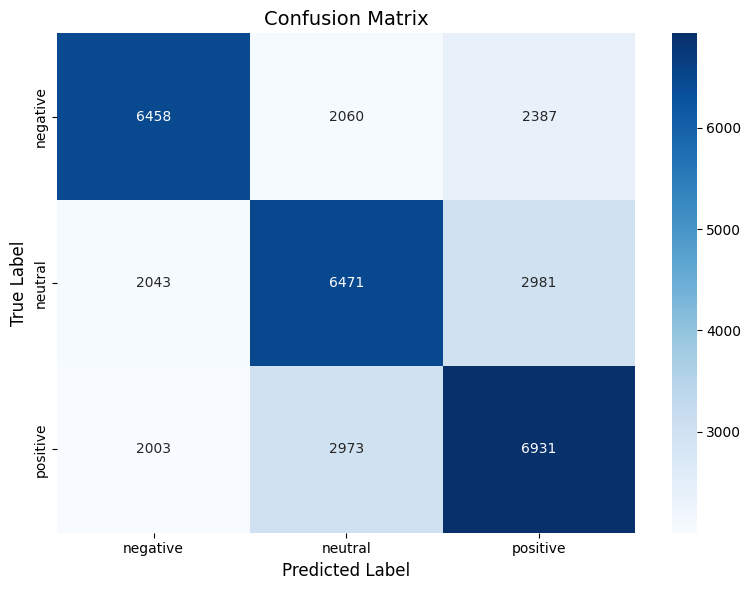

Macro ROC-AUC: 0.7590
________________________________________________________________________________

--------------------------------------------------------------------------------
EVALUATING XLM-ROBERTA TRANSFORMER MODEL ON TEST SET
________________________________________________________________________________
EVALUATION RESULTS
________________________________________________________________________________
Accuracy: 0.6141
Macro F1-Score: 0.6130

Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.65      0.64      0.64     10905
     neutral       0.59      0.53      0.56     11495
    positive       0.60      0.67      0.63     11907

    accuracy                           0.61     34307
   macro avg       0.61      0.61      0.61     34307
weighted avg       0.61      0.61      0.61     34307

-------------------------------------------------------

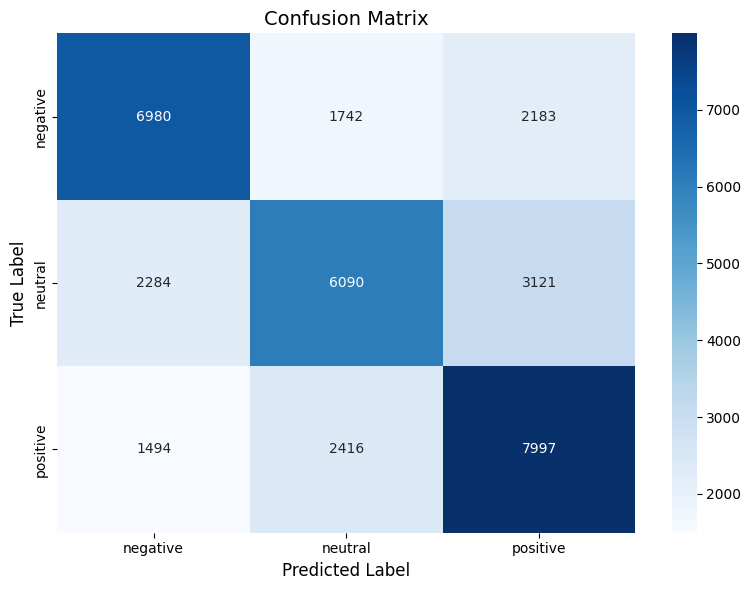

Macro ROC-AUC: 0.7976
________________________________________________________________________________


In [62]:
# EVALUATION FUNCTION (ACCURACY, F1, ROC-AUC, CONFUSION MATRIX)

def evaluate_model(model, data_loader, is_transformer=True):
    """Evaluate model on test data with comprehensive metrics."""
    model.eval()
    all_labels, all_preds = [], []
    all_probs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            if is_transformer:
                attention_mask = batch["attention_mask"].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
            else:
                outputs = model(input_ids=input_ids)
                logits = outputs["logits"]

            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    cm = confusion_matrix(all_labels, all_preds)

    print("EVALUATION RESULTS")
    print("_" * 80)
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print("-" * 80)
    print(classification_report(all_labels, all_preds,
                                target_names=["negative", "neutral", "positive"]))
    print("-" * 80)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["negative", "neutral", "positive"],
                yticklabels=["negative", "neutral", "positive"])
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    plt.tight_layout()
    plt.show()

    try:
        auc = roc_auc_score(all_labels, all_probs, multi_class="ovr", average="macro")
        print(f"Macro ROC-AUC: {auc:.4f}")
    except Exception as e:
        print(f"ROC-AUC could not be computed: {e}")

    print("_" * 80)
    return acc, f1, cm

# Evaluate LSTM Baseline on Test Set
print("\n")
print("EVALUATING LSTM BASELINE MODEL ON TEST SET")
print("_" * 80)
lstm_test_acc, lstm_test_f1, lstm_cm = evaluate_model(lstm_model, test_loader, is_transformer=False)

# Evaluate Transformer Model on Test Set (if available)
if transformer_model is not None:
    print("\n" + "-" * 80)
    print("EVALUATING XLM-ROBERTA TRANSFORMER MODEL ON TEST SET")
    print("_" * 80)
    transformer_test_acc, transformer_test_f1, transformer_cm = evaluate_model(
        transformer_model, test_loader, is_transformer=True
    )
else:
    print("\nTransformer model not available for evaluation.")
    transformer_test_acc, transformer_test_f1, transformer_cm = None, None, None


### 7.2. Example Predictions

Make predictions on sample texts to demonstrate model behavior on different languages and sentiment classes.


In [63]:
# EXAMPLE PREDICTIONS: Predict sentiment for sample texts

def predict_text(text, model, tokenizer, is_transformer=True):
    """Predict sentiment for a single text."""
    model.eval()

    # Clean text (if clean_text function is available)
    if 'clean_text' in globals():
        text_clean = clean_text(text)
    else:
        text_clean = text

    # Tokenize
    encoded = tokenizer(
        text_clean,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=max_length if 'max_length' in globals() else 128
    ).to(device)

    with torch.no_grad():
        if is_transformer:
            outputs = model(**encoded)
            logits = outputs.logits
        else:
            outputs = model(input_ids=encoded["input_ids"])
            logits = outputs["logits"]

        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_id = int(np.argmax(probs))

    # Get label mapping
    if 'id2label' in globals():
        pred_label = id2label[pred_id]
    else:
        label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
        pred_label = label_map[pred_id]

    print("-" * 80)
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {pred_label}")
    print(f"Probabilities:")
    print(f"  - Negative: {probs[0]:.4f}")
    print(f"  - Neutral:  {probs[1]:.4f}")
    print(f"  - Positive: {probs[2]:.4f}")
    print("-" * 80)

    return pred_label, probs

# Sample texts in different languages
sample_texts = [
    "Nimefurahi sana kwa huduma hii! 😍",  # Swahili positive
    "Service hii ni mbaya sana.",          # Swahili negative
    "I am not sure how I feel about this." # English neutral
]

print("\n")
print("EXAMPLE PREDICTIONS - XLM-ROBERTA TRANSFORMER MODEL")
print("_" * 80)

if transformer_model is not None and 'tokenizer' in globals():
    for text in sample_texts:
        predict_text(text, transformer_model, tokenizer, is_transformer=True)
        print()
else:
    print("Transformer model or tokenizer not available for predictions.")




EXAMPLE PREDICTIONS - XLM-ROBERTA TRANSFORMER MODEL
________________________________________________________________________________
--------------------------------------------------------------------------------
Text: Nimefurahi sana kwa huduma hii! 😍
Predicted Sentiment: negative
Probabilities:
  - Negative: 0.9881
  - Neutral:  0.0101
  - Positive: 0.0017
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Text: Service hii ni mbaya sana.
Predicted Sentiment: positive
Probabilities:
  - Negative: 0.0122
  - Neutral:  0.0201
  - Positive: 0.9677
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Text: I am not sure how I feel about this.
Predicted Sentiment: positive
Probabilities:
  - Negative: 0.0107
  - Neutral:  0.0747
  - Positive: 0.9146
------------------

### 7.3. Attention Visualization (Transformer)

Visualize attention weights from the transformer model to understand which tokens the model focuses on when making predictions.


XLMRobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.




ATTENTION VISUALIZATION - XLM-ROBERTA TRANSFORMER MODEL
________________________________________________________________________________


/tmp/ipython-input-2692373756.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores_top, y=tokens_top, palette="viridis")


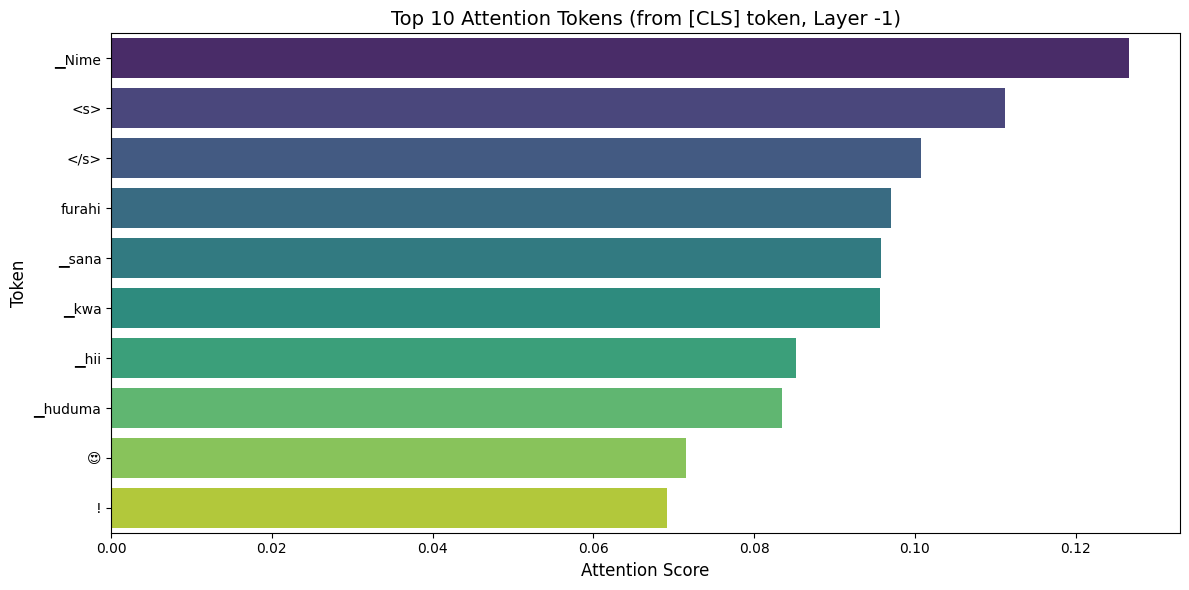


Text: Nimefurahi sana kwa huduma hii! 😍
Top 10 tokens by attention:
   1. ▁Nime                (score: 0.1267)
   2. <s>                  (score: 0.1113)
   3. </s>                 (score: 0.1008)
   4. furahi               (score: 0.0971)
   5. ▁sana                (score: 0.0958)
   6. ▁kwa                 (score: 0.0957)
   7. ▁hii                 (score: 0.0852)
   8. ▁huduma              (score: 0.0834)
   9. 😍                    (score: 0.0715)
  10. !                    (score: 0.0691)


In [64]:
# ATTENTION VISUALIZATION FOR TRANSFORMER MODELS

def visualize_attention(text, model, tokenizer, layer=-1, head_avg=True, top_k=10):
    """Visualize attention weights from transformer model."""
    model.eval()

    # Tokenize input
    encoded = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=max_length if 'max_length' in globals() else 128
    )
    encoded = {k: v.to(device) for k, v in encoded.items()}

    with torch.no_grad():
        outputs = model(**encoded, output_attentions=True)
        attentions = outputs.attentions  # tuple: (num_layers, batch, num_heads, seq_len, seq_len)

    # Extract attention from selected layer
    att_layer = attentions[layer][0]  # (num_heads, seq_len, seq_len)

    # Average over heads or use first head
    if head_avg:
        att_vec = att_layer.mean(dim=0)[0]  # attention from [CLS] to each token: (seq_len,)
    else:
        att_vec = att_layer[0, 0]  # head 0, from [CLS]

    # Get tokens and attention scores
    tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
    att_scores = att_vec.cpu().numpy()

    # Get top_k tokens by attention
    idx_sorted = np.argsort(-att_scores)[:top_k]
    tokens_top = [tokens[i] for i in idx_sorted]
    scores_top = [att_scores[i] for i in idx_sorted]

    # Visualize
    plt.figure(figsize=(12, 6))
    sns.barplot(x=scores_top, y=tokens_top, palette="viridis")
    plt.title(f"Top {top_k} Attention Tokens (from [CLS] token, Layer {layer})", fontsize=14)
    plt.xlabel("Attention Score", fontsize=12)
    plt.ylabel("Token", fontsize=12)
    plt.tight_layout()
    plt.show()

    print(f"\nText: {text}")
    print(f"Top {top_k} tokens by attention:")
    for i, (token, score) in enumerate(zip(tokens_top, scores_top), 1):
        print(f"  {i:2d}. {token:20s} (score: {score:.4f})")

# Example: Visualize attention for a sample text
if transformer_model is not None and 'tokenizer' in globals():
    print("\n")
    print("ATTENTION VISUALIZATION - XLM-ROBERTA TRANSFORMER MODEL")
    print("_" * 80)
    example_text = "Nimefurahi sana kwa huduma hii! 😍"
    visualize_attention(example_text, transformer_model, tokenizer)
else:
    print("Transformer model or tokenizer not available for attention visualization.")


## 8. Ablation Studies (Batch Size, Learning Rate, Sequence Length)

Investigate the impact of different hyperparameters (batch size, learning rate, sequence length) on model performance.



--------------------------------------------------------------------------------
STARTING ABLATION STUDY
________________________________________________________________________________
Testing 3 different configurations...
ABLATION CONFIG 1/3: {'batch_size': 8, 'lr': 2e-05, 'max_length': 128}
________________________________________________________________________________


Map:   0%|          | 0/63685 [00:00<?, ? examples/s]

Map:   0%|          | 0/13726 [00:00<?, ? examples/s]

Map:   0%|          | 0/34307 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training model with config: batch_size=8, lr=2e-05, max_length=128
------------------------------------------------------------
[TRANS] Epoch 1/3


  Train loss: 0.8998 | Val acc: 0.6357 | Val F1: 0.6310
  New best F1: 0.6310, model saved!
[TRANS] Epoch 2/3


  Train loss: 0.7203 | Val acc: 0.6628 | Val F1: 0.6606
  New best F1: 0.6606, model saved!
[TRANS] Epoch 3/3


  Train loss: 0.5979 | Val acc: 0.6783 | Val F1: 0.6789
  New best F1: 0.6789, model saved!
Transformer training completed. Best F1: 0.6789
Total training time: 117.6 minutes (1.96 hours)
EVALUATION RESULTS
________________________________________________________________________________
Accuracy: 0.6130
Macro F1-Score: 0.6129

Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.67      0.63      0.65     10905
     neutral       0.58      0.54      0.56     11495
    positive       0.59      0.67      0.63     11907

    accuracy                           0.61     34307
   macro avg       0.62      0.61      0.61     34307
weighted avg       0.61      0.61      0.61     34307

--------------------------------------------------------------------------------


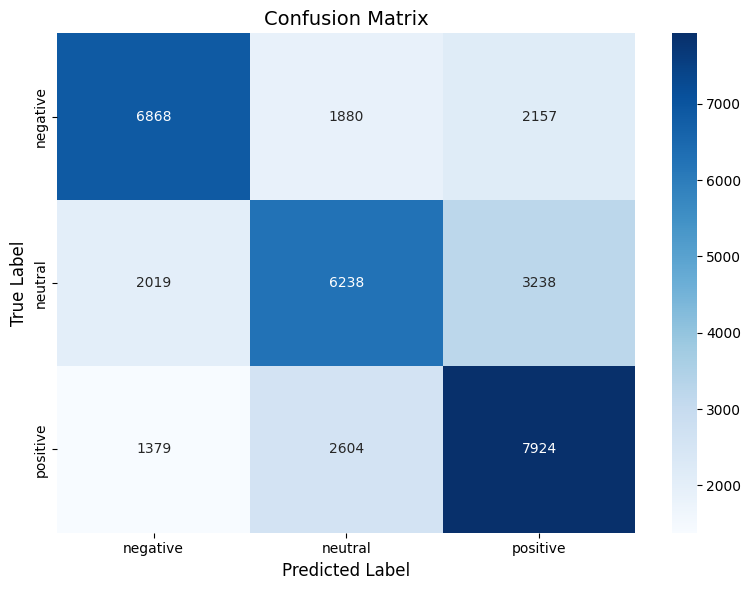

Macro ROC-AUC: 0.7975
________________________________________________________________________________

Config 1 completed: Acc=0.6130, F1=0.6129
ABLATION CONFIG 2/3: {'batch_size': 8, 'lr': 1e-05, 'max_length': 128}
________________________________________________________________________________

Training model with config: batch_size=8, lr=1e-05, max_length=128


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


------------------------------------------------------------
[TRANS] Epoch 1/3


Evaluating:  10%|█         | 178/1716 [00:09<01:21, 18.87it/s]

In [ ]:
# ABLATION STUDIES: Vary Batch Size, Learning Rate, Max Sequence Length

def run_ablation(configs):
    """Run ablation study with different hyperparameter configurations."""
    results = []

    for idx, cfg in enumerate(configs, 1):

        print(f"ABLATION CONFIG {idx}/{len(configs)}: {cfg}")
        print("_" * 80)

        # Update max_length for this configuration
        cfg_max_length = cfg["max_length"]

        # Re-tokenize with new max_length
        def tokenize_batch_dynamic(batch):
            encoded = tokenizer(
                batch["tweet"],
                truncation=True,
                padding="max_length",
                max_length=cfg_max_length
            )
            encoded["labels"] = batch["label_id"]
            return encoded

        # Tokenize datasets with new max_length
        train_tok_cfg = train_ds.map(tokenize_batch_dynamic, batched=True)
        val_tok_cfg = val_ds.map(tokenize_batch_dynamic, batched=True)
        test_tok_cfg = test_ds.map(tokenize_batch_dynamic, batched=True)

        # Format for PyTorch
        cols_local = ["input_ids", "attention_mask", "labels"]
        train_tok_cfg.set_format(type="torch", columns=cols_local)
        val_tok_cfg.set_format(type="torch", columns=cols_local)
        test_tok_cfg.set_format(type="torch", columns=cols_local)

        # Create DataLoaders with new batch size
        train_loader_cfg = DataLoader(train_tok_cfg, batch_size=cfg["batch_size"], shuffle=True)
        val_loader_cfg = DataLoader(val_tok_cfg, batch_size=cfg["batch_size"])
        test_loader_cfg = DataLoader(test_tok_cfg, batch_size=cfg["batch_size"])

        # Create fresh transformer model for this configuration
        print(f"\nTraining model with config: batch_size={cfg['batch_size']}, lr={cfg['lr']}, max_length={cfg_max_length}")
        model_cfg = AutoModelForSequenceClassification.from_pretrained(
            transformer_name,
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id
        ).to(device)

        # Train model
        train_transformer(
            model_cfg,
            train_loader_cfg,
            val_loader_cfg,
            epochs=3,  # Reduced epochs for ablation study
            lr=cfg["lr"],
            patience=1
        )

        # Evaluate on test set
        test_acc, test_f1, _ = evaluate_model(model_cfg, test_loader_cfg, is_transformer=True)

        results.append({
            "batch_size": cfg["batch_size"],
            "lr": cfg["lr"],
            "max_length": cfg["max_length"],
            "test_acc": test_acc,
            "test_f1": test_f1
        })

        print(f"\nConfig {idx} completed: Acc={test_acc:.4f}, F1={test_f1:.4f}")

    return pd.DataFrame(results)

# Define ablation study configurations
ablation_configs = [
    {"batch_size": 8,  "lr": 2e-5, "max_length": 128},  # Baseline
    {"batch_size": 8,  "lr": 1e-5, "max_length": 128},  # Lower learning rate
    {"batch_size": 16, "lr": 2e-5, "max_length": 64},   # Larger batch, shorter sequences
]

print("\n" + "-" * 80)
print("STARTING ABLATION STUDY")
print("_" * 80)
print(f"Testing {len(ablation_configs)} different configurations...")

if transformer_model is not None:
    ablation_results = run_ablation(ablation_configs)

    print("\n" + "-" * 80)
    print("ABLATION STUDY RESULTS")
    print("_" * 80)
    print(ablation_results.to_string(index=False))
else:
    print("Transformer model not available for ablation study.")


## 9. Cross-Lingual Testing (Train on Swahili, Test on Amharic)

Test the model's ability to transfer knowledge across languages by training on one language (Swahili) and evaluating on another (Amharic).


In [ ]:
# CROSS-LINGUAL TESTING: Train on Swahili, Test on Amharic

print("CROSS-LINGUAL EXPERIMENT: Train on Swahili, Test on Amharic")
print("_" * 80)

# Load separate language datasets
print("\nLoading Swahili and Amharic datasets")
swa_raw = load_dataset("HausaNLP/AfriSenti-Twitter", "swa", trust_remote_code=True)
amh_raw = load_dataset("HausaNLP/AfriSenti-Twitter", "amh", trust_remote_code=True)

# Preprocess and label datasets
def preprocess_and_label(ds):
    """Apply preprocessing and label encoding to dataset."""
    if 'preprocess_batch' in globals():
        ds = ds.map(preprocess_batch, batched=True)
    if 'encode_labels' in globals():
        ds = ds.map(encode_labels, batched=True)
    return ds

swa_raw = preprocess_and_label(swa_raw)
amh_raw = preprocess_and_label(amh_raw)

print(f"Swahili dataset loaded: {len(swa_raw['train'])} train, {len(swa_raw['validation'])} val")
print(f"Amharic dataset loaded: {len(amh_raw['test'])} test samples")

# Tokenization function
def tokenize_simple(ds, max_length=128):
    """Tokenize dataset with specified max_length."""
    def _tok(batch):
        encoded = tokenizer(
            batch["tweet"],
            truncation=True,
            padding="max_length",
            max_length=max_length
        )
        encoded["labels"] = batch["label_id"]
        return encoded
    ds_tok = ds.map(_tok, batched=True)
    ds_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return ds_tok

# Tokenize datasets
print("\nTokenizing datasets...")
swa_train = tokenize_simple(swa_raw["train"])
swa_val = tokenize_simple(swa_raw["validation"])
amh_test = tokenize_simple(amh_raw["test"])

# Create DataLoaders
swa_train_loader = DataLoader(swa_train, batch_size=8, shuffle=True)
swa_val_loader = DataLoader(swa_val, batch_size=8)
amh_test_loader = DataLoader(amh_test, batch_size=8)

print(f"DataLoaders created: {len(swa_train_loader)} train batches, {len(swa_val_loader)} val batches, {len(amh_test_loader)} test batches")

# Create new transformer model for cross-lingual experiment
print("\nCreating fresh transformer model for cross-lingual training...")
xling_model = AutoModelForSequenceClassification.from_pretrained(
    transformer_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
).to(device)

print(f"Model created: {transformer_name}")

# Train on Swahili only
print("TRAINING ON SWAHILI DATA ONLY")
print("_" * 80)
train_transformer(xling_model, swa_train_loader, swa_val_loader, epochs=5, lr=2e-5, patience=2)

# Evaluate on Amharic test set
print("EVALUATING ON AMHARIC TEST SET (Cross-Lingual Transfer)")
print("_" * 80)
print("This tests the model's ability to transfer knowledge from Swahili to Amharic.")

xling_test_acc, xling_test_f1, xling_cm = evaluate_model(xling_model, amh_test_loader, is_transformer=True)

print("CROSS-LINGUAL EXPERIMENT SUMMARY")
print("_" * 80)
print(f"Training Language: Swahili (swa)")
print(f"Test Language: Amharic (amh)")
print(f"Test Accuracy: {xling_test_acc:.4f}")
print(f"Test F1-Score: {xling_test_f1:.4f}")
print("_" * 80)
print("\nNote: Lower performance compared to same-language training is expected,")
print("      as the model must transfer knowledge across different languages.")
